## Introduction
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [1]:
!pip install pandas --upgrade
!pip install pyLDAvis --upgrade

In [2]:
# Importing modules
from google.colab import drive
import pandas as pd
import os
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle

drive.mount('/content/gdrive')

# Read data into papers
papers = pd.read_csv('/content/gdrive/MyDrive/papers.csv')

# Print head
papers.head()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packa

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [3]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
6240,2017,Inference in Graphical Models via Semidefinite...,Maximum A posteriori Probability (MAP) inferen...,Inference in Graphical Models\nvia Semidefinit...
5203,2015,Smooth and Strong: MAP Inference with Linear C...,Maximum a-posteriori (MAP) inference is an imp...,Smooth and Strong:\nMAP Inference with Linear ...
3431,2010,Implicit Differentiation by Perturbation,This paper proposes a simple and efficient fin...,Implicit Differentiation by Perturbation\n\nJu...
6021,2016,The Power of Optimization from Samples,We consider the problem of optimization from s...,The Power of Optimization from Samples\nEric B...
6268,2017,Recycling Privileged Learning and Distribution...,Equipping machine learning models with ethical...,Recycling Privileged Learning\nand Distributio...


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [4]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<input>:5: DeprecationWarning: invalid escape sequence \.
<ipython-input-4-854fdd4abaf9>:5: DeprecationWarning: invalid escape sequence \.
  papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))


6240    inference in graphical models\nvia semidefinit...
5203    smooth and strong:\nmap inference with linear ...
3431    implicit differentiation by perturbation\n\nju...
6021    the power of optimization from samples\neric b...
6268    recycling privileged learning\nand distributio...
Name: paper_text_processed, dtype: object

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

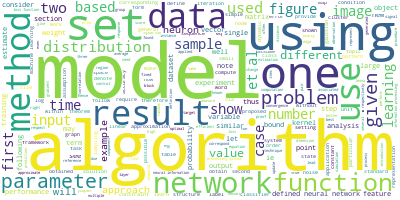

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['inference', 'graphical', 'models', 'via', 'semidefinite', 'programming', 'hierarchies', 'murat', 'erdogdu', 'microsoft', 'research', 'erdogdu', 'cstorontoedu', 'yash', 'deshpande', 'mit', 'microsoft', 'research', 'yash', 'mitedu', 'andrea', 'montanari', 'stanford', 'university', 'montanari', 'stanfordedu', 'abstract', 'maximum', 'posteriori', 'probability']


In [7]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 2), (4, 8), (5, 2), (6, 1), (7, 1), (8, 2), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4), (16, 1), (17, 1), (18, 1), (19, 15), (20, 12), (21, 1), (22, 1), (23, 4), (24, 1), (25, 1), (26, 2), (27, 3), (28, 1), (29, 2)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [8]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.007*"learning" + 0.006*"network" + 0.005*"model" + 0.005*"algorithm" + '
  '0.004*"set" + 0.004*"networks" + 0.004*"figure" + 0.004*"data" + '
  '0.003*"using" + 0.003*"function"'),
 (1,
  '0.006*"learning" + 0.006*"model" + 0.005*"function" + 0.005*"algorithm" + '
  '0.005*"data" + 0.005*"set" + 0.004*"models" + 0.003*"using" + '
  '0.003*"number" + 0.003*"distribution"'),
 (2,
  '0.006*"learning" + 0.006*"data" + 0.005*"using" + 0.004*"model" + '
  '0.003*"algorithm" + 0.003*"set" + 0.003*"matrix" + 0.003*"one" + '
  '0.003*"function" + 0.003*"figure"'),
 (3,
  '0.007*"learning" + 0.006*"model" + 0.006*"data" + 0.005*"algorithm" + '
  '0.005*"function" + 0.004*"problem" + 0.003*"models" + 0.003*"using" + '
  '0.003*"two" + 0.003*"set"'),
 (4,
  '0.006*"learning" + 0.005*"using" + 0.005*"model" + 0.004*"algorithm" + '
  '0.004*"data" + 0.004*"figure" + 0.004*"set" + 0.004*"training" + '
  '0.003*"models" + 0.003*"also"'),
 (5,
  '0.008*"learning" + 0.006*"function" + 0.005*"

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [9]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.000812  0.005505       1        1  16.953559
5     -0.004965 -0.009109       2        1  14.520506
3      0.005702  0.001985       3        1  10.249878
8      0.007772  0.003251       4        1  10.065437
0     -0.010343  0.001365       5        1   9.880389
1      0.003024 -0.000466       6        1   9.814592
2      0.001082  0.000021       7        1   8.737172
7      0.009357 -0.007210       8        1   8.141266
4     -0.001869  0.006684       9        1   6.807701
6     -0.008948 -0.002027      10        1   4.829501, topic_info=             Term         Freq        Total Category  logprob  loglift
2222      network   664.000000   664.000000  Default  30.0000  30.0000
998         using   931.000000   931.000000  Default  29.0000  29.0000
501      learning  1636.000000  1636.000000  Default  28.0000  28.0000
349      function  1025.000000  1025.000000  Default  27.0000  27.0000
980           two   649.000000   649.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
995          used    23.639970   537.600645  Topic10  -6.1927  -0.0938
20     algorithms    22.946477   511.084164  Topic10  -6.2225  -0.0729
668   performance    21.513244   408.759180  Topic10  -6.2870   0.0860
574        models    24.538250   691.117464  Topic10  -6.1554  -0.3076
23           also    24.067926   640.900989  Topic10  -6.1748  -0.2516

[863 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3750      1  0.386180  action
3750      2  0.077236  action
3750      3  0.089119  action
3750      4  0.089119  action
3750      5  0.095060  action
...     ...       ...     ...
7085      4  0.139104    zmin
7085      5  0.278209    zmin
7085      6  0.139104    zmin
7085      8  0.139104    zmin
7085     10  0.139104    zmin

[4089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 9, 1, 2, 3, 8, 5, 7])

** **
#### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### References:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
